In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mylibrary.nnlib as tnn
import mylibrary.splinelib as tsp

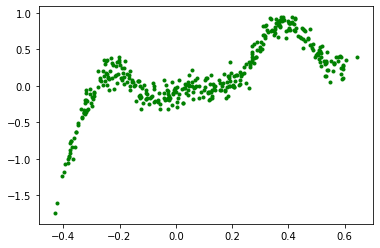

In [2]:
x = np.linspace(0,1,400)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y = (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - 0.4 #x.mean() # good practice to zero-center x in linear mapping
sortindx = np.argsort(x)
x = x[sortindx]
y = y[sortindx]
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)
plt.scatter(x, y, marker='.', color='g')

## Using inverse function without optimization(after initialization)

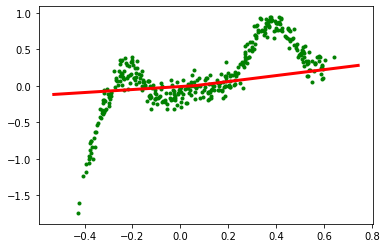

In [3]:
max_points = 3
lr=0.1
spline = tsp.Spline1D(max_points, x, y)
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, color='r', lw=3)

In [4]:
Y = spline.forward(x)
dy = Y-y
dx = spline.backward(dy)

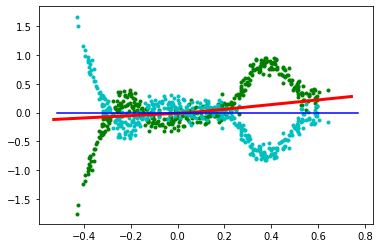

In [5]:
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, color='r', lw=3)
plt.scatter(x, dy, marker='.', color='c')
plt.plot(x*1.2, np.zeros_like(x), color='b')

#### Gradient of x of forward function calculation

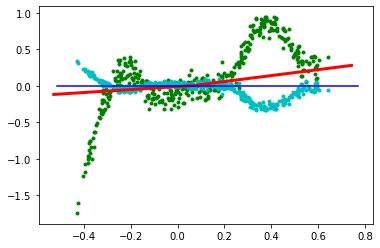

In [6]:
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, color='r', lw=3)
plt.scatter(x, dx, marker='.', color='c')
plt.plot(x*1.2, np.zeros_like(x), color='b')

## Reverse Function 

In [7]:
def reverse0(self:tsp.Spline1D, y):
    x = np.zeros_like(self.input)
    for i in range(self.n_points-1):
        xpossible = self.diffX[i]/self.diffY[i] *(y - self.Y[i]) + self.X[i]
        x += xpossible*self.rangeX[i]
    return x

### Reverse using the target

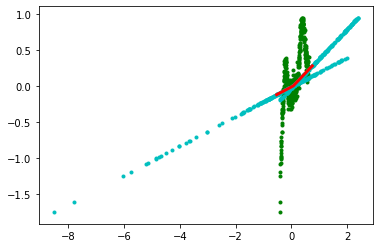

In [8]:
x_ = reverse0(spline, y)
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, color='r', lw=3)
plt.scatter(x_, y, marker='.', color='c')

#### Gradient of inverse function calculation

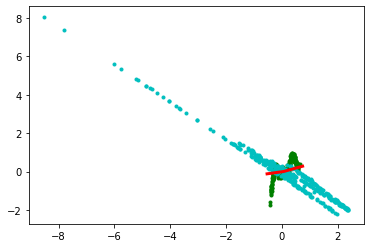

In [9]:
dx_ = x - x_ ## xn = xo - dx
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, color='r', lw=3)
plt.scatter(x_, dx_, marker='.', color='c')

## Finding gradients of spline points wrt gradient of inverse function

In [10]:
def _backward_X_(self:tsp.Spline1D, target, del_recons):

    consts = np.zeros((self.n_points-1, target.shape[0]))
    for i in range(self.n_points-1):
        consts[i] = (target-self.Y[i])/self.diffY[i]

    dX = np.zeros((self.n_points, target.shape[0]))

    dX[0] = (-1* consts[0] +1) *self.rangeX[0]
    dX[-1] = consts[-1] *self.rangeX[-1]

    for i in range(1, self.n_points-1):
            a = consts[i-1]*self.rangeX[i-1]
            b = (-1* consts[i] +1)*self.rangeX[i]
            dX[i] = a+b
    dX = dX*del_recons
    ## can choose any three options for gradient of Y
#     dY = dY.sum(axis=1)/self.rangeX_n

    # dY_= dY.sum(axis=1)/self.rangeX_n
    # dY = dY.mean(axis=1)
    # dY[0], dY[-1] = dY_[0], dY_[-1]

    dX = dX.mean(axis=1)

#     self.del_Y = dY
#     return self.del_Y
    return dX

def _backward_Y_(self:tsp.Spline1D, target, del_recons):

    consts = np.zeros((self.n_points-1, target.shape[0]))
    for i in range(self.n_points-1):
        consts[i] = self.diffX[i]/(self.diffY[i]**2)

    dY = np.zeros((self.n_points, target.shape[0]))
    dY[0] = consts[0]*(target - self.Y[1])*self.rangeX[0]
    dY[-1] = -1*consts[-1]*(target - self.Y[-2])*self.rangeX[-1]

    for i in range(1, self.n_points-1):
            a = -1*consts[i-1]*(target - self.Y[i-1])*self.rangeX[i-1]
            b = consts[i]*(target - self.Y[i+1])*self.rangeX[i]
            dY[i] = a+b
    dY = dY*del_recons

    ## can choose any of below options for calculating gradient of X
    dY = dY.mean(axis=1)
    # dX = dX.sum(axis=1)/self.rangeX_n

#     self.del_X = dX
#     return self.del_X
    return dY


def _backward_target_(self:tsp.Spline1D, del_recons):
    dtarg = np.zeros_like(self.output)
    for i in range(self.n_points-1):
        dtarg = dtarg + self.diffX[i]/self.diffY[i] *self.rangeX[i]

    dtarg = dtarg*del_recons
    return dtarg

In [11]:
spline.del_X, spline.del_Y

(array([-0.00649997,  0.02651986,  0.0286802 ]),
 array([ 0.06796181, -0.05839537, -0.13223332]))

In [12]:
del_target = _backward_target_(spline, dx_)

In [13]:
del_X_inv = _backward_X_(spline, y, dx_)
del_Y_inv = _backward_Y_(spline, y, dx_)

In [14]:
del_X_inv, del_Y_inv

(array([ 2.5729737 , -1.75807416, -0.94302029]),
 array([-12.57680245,  10.03782409,   2.3152583 ]))

In [15]:
spline.del_X += del_X_inv
spline.del_X/=2
spline.del_Y += del_Y_inv
spline.del_Y/=2

In [16]:
spline.del_X, spline.del_Y

(array([ 1.28323686, -0.86577715, -0.45717005]),
 array([-6.25442032,  4.98971436,  1.09151249]))

In [17]:
spline.update()

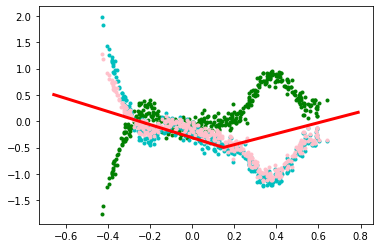

In [18]:
Y = spline.forward(x)
dy = Y-y
dx = spline.backward(dy)
x_ = reverse0(spline, y)
dx_ = x - x_
dy_ = _backward_target_(spline, dx_)

plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, color='r', lw=3)
plt.scatter(x, dy, marker='.', color='c')
plt.scatter(x, dy_, marker='.', color='pink')

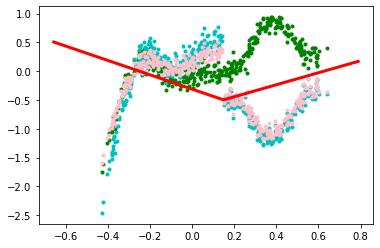

In [19]:
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, color='r', lw=3)
plt.scatter(x, dx, marker='.', color='c')
plt.scatter(x, dx_, marker='.', color='pink')

## Doing the optimization continuously

In [20]:
# x = np.linspace(0.4,0.8,400)
# noise = np.random.normal(0,0.02, x.shape)
# x = x + noise
# y = (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
# noise = np.random.normal(0,0.1, x.shape)
# y = y + noise
# x = x - 0.4 #x.mean() # good practice to zero-center x in linear mapping
# sortindx = np.argsort(x)
# x = x[sortindx]*2.5
# y = y[sortindx]
# xx = x.reshape(-1,1)
# yy = y.reshape(-1,1)
# %matplotlib inline
# plt.scatter(x, y, marker='.', color='g')

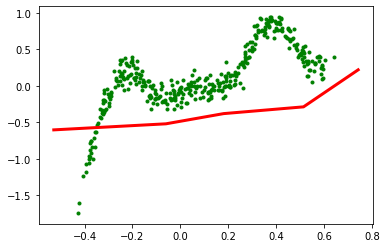

In [21]:
max_points = 5
lr=0.03
spline = tsp.Spline1D(max_points, x, y)
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, color='r', lw=3)

In [ ]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

for step in range(100000):

    Y = spline.forward(x)
    dy = Y-y
    dx = spline.backward(dy)
#     spline.update(lr)
    
    Y = spline.forward(x)
    dy = Y-y
    dx = spline.backward(dy)
    x_ = reverse0(spline, y)
    dx_ = x_ - x
    
    del_X_inv = _backward_X_(spline, y, dx_)
    del_Y_inv = _backward_Y_(spline, y, dx_)
    dy_ = _backward_target_(spline, dx_)

#     del_X_inv = _backward_X_(spline, y, dx)
#     del_Y_inv = _backward_Y_(spline, y, dx)
#     dy_ = _backward_target_(spline, dx)
    
#     dx = spline.backward(dy_)
    
    
    spline.del_X += del_X_inv
    spline.del_X/=2
    spline.del_Y += del_Y_inv
    spline.del_Y/=2
    
#     spline.del_X = del_X_inv
#     spline.del_Y = del_Y_inv
    
    
    spline.update(lr)
    
    if step % 1000 == 0:
        spline._remove_close_points_()
        spline._combine_linear_points_()
        spline._remove_no_input_points_()
        spline._add_new_point_()
        
    if step % 100 == 0:            
        errory = (dy**2).mean()
        errorx = (dx_**2).mean()
        error = errorx+ errory
        print('_______________________')
        print("Steps", step)
        print("ErrorY", errory)
        print("ErrorX", errorx)
        print("Error", error)
        
        ax.clear()
        epsilon=0.4
        plt.xlim(x.min()-epsilon, x.max()+epsilon)
        plt.ylim(y.min()-epsilon, y.max()+epsilon)
        plt.scatter(x, y, marker='.', color='g')
        plt.plot(spline.X, spline.Y, marker='.', color='r')
        
        plt.scatter(x, dy, marker='.', color='blue')
#         plt.scatter(x, dy_, marker='.', color='pink')
        
        plt.scatter(x, dx, marker='.', color='c')
#         plt.scatter(x, dx_, marker='.', color='pink')
        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

_______________________
Steps 0
ErrorY 0.44882232430569835
ErrorX 7.151702304724977
Error 7.600524629030676


_______________________
Steps 100
ErrorY 0.06920079030279169
ErrorX 0.017958268658825525
Error 0.08715905896161721


_______________________
Steps 200
ErrorY 0.03218386909703239
ErrorX 0.0070363044776547146
Error 0.03922017357468711


_______________________
Steps 300
ErrorY 0.023053006623846482
ErrorX 0.005162520749442019
Error 0.0282155273732885


_______________________
Steps 400
ErrorY 0.0195566976231791
ErrorX 0.004397361096729374
Error 0.023954058719908473


_______________________
Steps 500
ErrorY 0.018512675626041235
ErrorX 0.004592064466345997
Error 0.023104740092387232


_______________________
Steps 600
ErrorY 0.0180735406360085
ErrorX 0.004747643056439721
Error 0.02282118369244822


_______________________
Steps 700
ErrorY 0.01783521452947747
ErrorX 0.0048740386730776394
Error 0.02270925320255511


_______________________
Steps 800
ErrorY 0.017665378730440634
ErrorX

_______________________
Steps 6900
ErrorY 0.017450744005266278
ErrorX 0.005226823856578345
Error 0.022677567861844623


_______________________
Steps 7000
ErrorY 0.01745074391088773
ErrorX 0.005226824453297481
Error 0.022677568364185212


_______________________
Steps 7100
ErrorY 0.017450743816121102
ErrorX 0.005226825051966835
Error 0.022677568868087937


_______________________
Steps 7200
ErrorY 0.01745074372101471
ErrorX 0.005226825652502447
Error 0.022677569373517156


_______________________
Steps 7300
ErrorY 0.017450743625605298
ErrorX 0.005226826254841877
Error 0.022677569880447175


_______________________
Steps 7400
ErrorY 0.017450743529920775
ErrorX 0.005226826858939167
Error 0.022677570388859942


_______________________
Steps 7500
ErrorY 0.017450743433982296
ErrorX 0.005226827464760938
Error 0.022677570898743234


_______________________
Steps 7600
ErrorY 0.017450743337805847
ErrorX 0.005226828072283467
Error 0.022677571410089314


_______________________
Steps 7700
ErrorY 

_______________________
Steps 13800
ErrorY 0.017450736976486355
ErrorX 0.005226869217253844
Error 0.0226776061937402


_______________________
Steps 13900
ErrorY 0.017450736867133075
ErrorX 0.005226869942665979
Error 0.022677606809799054


_______________________
Steps 14000
ErrorY 0.01745073675754943
ErrorX 0.0052268706702499135
Error 0.022677607427799343


_______________________
Steps 14100
ErrorY 0.017450736647734607
ErrorX 0.005226871400016676
Error 0.022677608047751284


_______________________
Steps 14200
ErrorY 0.017450736537687778
ErrorX 0.005226872131977366
Error 0.022677608669665145


_______________________
Steps 14300
ErrorY 0.017450736427408117
ErrorX 0.0052268728661431715
Error 0.02267760929355129


_______________________
Steps 14400
ErrorY 0.017450736316894786
ErrorX 0.005226873602525363
Error 0.02267760991942015


_______________________
Steps 14500
ErrorY 0.01745073620614696
ErrorX 0.005226874341135274
Error 0.022677610547282234


_______________________
Steps 14600


_______________________
Steps 20700
ErrorY 0.01745072884436778
ErrorX 0.005226925020571357
Error 0.022677653864939137


_______________________
Steps 20800
ErrorY 0.01745072871699084
ErrorX 0.00522692592655098
Error 0.022677654643541822


_______________________
Steps 20900
ErrorY 0.01745072858931763
ErrorX 0.005226926835693746
Error 0.022677655425011378


_______________________
Steps 21000
ErrorY 0.017450728461347053
ErrorX 0.005226927748018342
Error 0.022677656209365394


_______________________
Steps 21100
ErrorY 0.017450728333077994
ErrorX 0.005226928663543598
Error 0.02267765699662159


_______________________
Steps 21200
ErrorY 0.017450728204509346
ErrorX 0.005226929582288501
Error 0.022677657786797846


_______________________
Steps 21300
ErrorY 0.017450728075639993
ErrorX 0.005226930504272201
Error 0.022677658579912194


_______________________
Steps 21400
ErrorY 0.017450727946468812
ErrorX 0.005226931429514014
Error 0.022677659375982828


_______________________
Steps 21500
E

_______________________
Steps 27600
ErrorY 0.01745075470607125
ErrorX 0.005226748804840368
Error 0.022677503510911617


_______________________
Steps 27700
ErrorY 0.01745075463431637
ErrorX 0.005226749218215029
Error 0.022677503852531398


_______________________
Steps 27800
ErrorY 0.017450754562260955
ErrorX 0.0052267496327733235
Error 0.022677504195034278


_______________________
Steps 27900
ErrorY 0.017450754489943453
ErrorX 0.005226750048447348
Error 0.022677504538390802


_______________________
Steps 28000
ErrorY 0.017450754417394354
ErrorX 0.005226750465183704
Error 0.022677504882578057


_______________________
Steps 28100
ErrorY 0.017450754344637866
ErrorX 0.005226750882940504
Error 0.02267750522757837


_______________________
Steps 28200
ErrorY 0.01745075427169318
ErrorX 0.005226751301685045
Error 0.022677505573378227


_______________________
Steps 28300
ErrorY 0.017450754198575474
ErrorX 0.0052267517213919435
Error 0.02267750591996742


_______________________
Steps 28400

_______________________
Steps 34500
ErrorY 0.017450749416814956
ErrorX 0.005226779567187066
Error 0.02267752898400202


_______________________
Steps 34600
ErrorY 0.017450749335641554
ErrorX 0.00522678004770842
Error 0.022677529383349975


_______________________
Steps 34700
ErrorY 0.017450749254331877
ErrorX 0.005226780529306557
Error 0.022677529783638434


_______________________
Steps 34800
ErrorY 0.01745074917288552
ErrorX 0.005226781011985601
Error 0.02267753018487112


_______________________
Steps 34900
ErrorY 0.017450749091302068
ErrorX 0.005226781495749698
Error 0.022677530587051766


_______________________
Steps 35000
ErrorY 0.017450749009581105
ErrorX 0.005226781980603014
Error 0.02267753099018412


_______________________
Steps 35100
ErrorY 0.01745074892772222
ErrorX 0.005226782466549744
Error 0.022677531394271963


_______________________
Steps 35200
ErrorY 0.017450748845724992
ErrorX 0.0052267829535940944
Error 0.022677531799319087


_______________________
Steps 35300
E

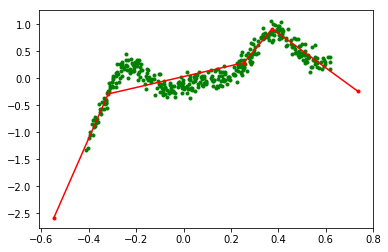

In [23]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.plot(spline.X, spline.Y, marker='.', color='r')